**Pregunta N°1 - Segundo Parcial - SIS420**

**Introducción.**

En este cuadernillo se realizará el clustering.

**Objetivo.**

Usar el algoritmo K-Means para proporcionar etiquetas detro de un conjunto de datos.

**Declaración de las Librerías.** Primeramente, es necesario declarar cada una de las librerías a usar, así nos enfocaremos cómodamente en el algoritmo.

In [3]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline

Mounted at /content/gdrive


# **Algoritmo K-means-**

**Funciones para carga y procesamiento del dataset.**

In [4]:
def cargarDataset(_dataset):
  # Función para cargar un conjunto de datos desde un archivo CSV.
  dataset = pd.read_csv(_dataset, sep=';', header=0, decimal=',')
  # Lee el archivo CSV especificado y carga los datos en un DataFrame de pandas.
  valores_unicos = dataset.iloc[:, 0].nunique()
  # Comparar con el 90% del total de filas
  datos = {}
  # Inicializa un diccionario para almacenar los datos categóricos únicos.
  columnas = dataset.columns[dataset.dtypes == 'object'].tolist()
  # Obtiene una lista de columnas que contienen tipos de datos 'object'.
  for columna in columnas:
    # Itera sobre las columnas cuyos datos son de tipo 'object'.
    datos[columna] = dataset[columna].drop_duplicates().values
    # Obtiene los valores únicos de cada columna y los almacena en el diccionario "datos".
  datos_num = {}
  # Inicializa un diccionario para almacenar los valores categóricos y sus correspondientes valores numéricos.
  for columna, valores in datos.items():
    # Itera sobre las columnas y sus valores únicos.
    indice_reemp = 0
    datos_num_col = {}
    # Inicializa un diccionario para almacenar los valores numéricos correspondientes a los valores categóricos.
    for valor in valores:
      # Itera sobre los valores únicos de la columna.
      if valor not in datos_num_col and not pd.isnull(valor):
        # Si el valor no está presente en el diccionario y no es nulo:
        datos_num_col[valor] = indice_reemp
        indice_reemp += 1
        # Asigna un valor numérico al valor categórico y actualiza el índice.
    if np.nan not in datos_num_col:
      datos_num_col[np.nan] = 0
      # Si no hay un valor numérico asignado para NaN, asigna 0.
    datos_num[columna] = datos_num_col
    # Asigna el diccionario de valores numéricos al diccionario principal.
  for columna, d_n in datos_num.items():
    # Itera sobre las columnas y sus diccionarios de valores numéricos.
    dataset[columna] = dataset[columna].replace(d_n)
    # Reemplaza los valores categóricos con sus equivalentes numéricos en el DataFrame.
  dataset = dataset.fillna(0)
  # Rellena los valores nulos en el DataFrame con ceros.
  return dataset
  # Devuelve el DataFrame procesado.

def normalizarCaracteristicas(X):
      media = np.mean(X, axis=0)
      desviacion_estandar = np.std(X, axis=0)
      desviacion_estandar[desviacion_estandar == 0] = 1
      X_norm = (X - media) / desviacion_estandar
      return X_norm

**Funciones para las respectivas gráficas.**

In [5]:
def graficar_fronteras_decision(clusterizador, X, caracteristicas=[7, 8], resolucion=1000, mostrar_centroides=True):
    # Función para graficar las fronteras de decisión de un clusterizador dado y los datos de entrada.
    X_vis = X[:, caracteristicas]
    # Selecciona las características específicas para la visualización.
    minimos = X_vis.min(axis=0) - 1
    maximos = X_vis.max(axis=0) + 1
    # Calcula los límites para la gráfica.
    xx, yy = np.meshgrid(np.linspace(minimos[0], maximos[0], resolucion),
                         np.linspace(minimos[1], maximos[1], resolucion))
    # Crea una malla de puntos para la visualización.
    malla = np.c_[xx.ravel(), yy.ravel()]
    malla_completa = np.zeros((len(malla), clusterizador.n_features_in_))
    malla_completa[:, caracteristicas] = malla
    # Prepara la malla completa para la predicción.
    Z = clusterizador.predict(malla_completa)
    Z = Z.reshape(xx.shape)
    # Realiza la predicción sobre la malla.
    plt.contourf(xx, yy, Z, alpha=0.5, cmap='Pastel2')
    plt.contour(xx, yy, Z, linewidths=1, colors='k')
    # Grafica las fronteras de decisión.
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusterizador.labels_, s=1)
    # Grafica los puntos de datos.
    graficar_datos(X)
    # Llama a la función para graficar los datos originales.
    if mostrar_centroides:
        graficar_centroides(clusterizador.cluster_centers_[:, caracteristicas])
        # Si se especifica, grafica los centroides de los clusters.
def graficar_centroides(centroides, color_circulo='w', color_cruz='k'):
    # Función para graficar los centroides de los clusters.
    plt.scatter(centroides[:, 0], centroides[:, 1],
                marker='o', s=10, linewidths=8,
                color=color_circulo, zorder=10, alpha=0.9)
    plt.scatter(centroides[:, 0], centroides[:, 1],
                marker='x', s=2, linewidths=10,
                color=color_cruz, zorder=11, alpha=1)
    # Grafica los centroides con círculos y cruces.
def graficar_datos(X):
    # Función para graficar los datos originales.
    plt.plot(X[:, 7], X[:, 8], 'k.', markersize=2)
    # Grafica los datos en el espacio de características especificado.
def graficar_clusters(X, y=None):
    # Función para graficar los clusters.
    plt.scatter(X[:, 7], X[:, 8], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    # Grafica los clusters con colores específicos (si se proporcionan) y etiqueta los ejes.

def graficar_todas_caracteristicas(clusterizador, X):
    n_features = X.shape[1]
    for i in range(n_features - 1):
        for j in range(i + 1, n_features):
            plt.figure(figsize=(8, 6))
            graficar_fronteras_decision(clusterizador, X, caracteristicas=[i, j])
            plt.title(f'Fronteras de decisión usando características {i+1} y {j+1}')
            plt.show()

**Función para encontrar el mejor número posible de grupos.** La puntuación de Silhouette se utiliza como medida de la calidad de los clusters, donde valores más altos indican una mejor separación entre los clusters.

In [6]:
def encontrar_numero_optimo_grupos(X, n=10):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Entrena modelos MiniBatchKMeans con diferentes números de clusters.
    kmeans_por_k = [MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100, n_init=10).fit(X) for k in range(1, n + 1)]

    # Calcula la puntuación de Silhouette para cada modelo (excepto el primero, que no tiene sentido).
    puntuaciones_silhouette = [silhouette_score(X, modelo.labels_) for modelo in kmeans_por_k[1:]]

    # Encuentra el número óptimo de clusters basado en la puntuación de Silhouette.
    k_optimo = np.argmax(puntuaciones_silhouette) + 2

    # Gráfico de la puntuación de Silhouette para cada número de clusters.
    print("Gráfico de la puntuación de Silhouette")
    plt.figure(figsize=(8, 3))
    plt.plot(range(0, n - 1), puntuaciones_silhouette, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.axis([0, n, -1, 1])
    plt.show()

    # Gráficos de los coeficientes de Silhouette para cada número de clusters.
    print("Gráficos de los coeficientes de Silhouette por cluster")
    plt.figure(figsize=(n + 1, 10))
    for k in range(2, n + 1):
        plt.subplot(3, 3, k - 1)
        y_pred = kmeans_por_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)
        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding
        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")
        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)
        plt.axvline(x=puntuaciones_silhouette[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)

    plt.show()

    # Devuelve el número óptimo de clusters encontrado.
    return k_optimo

*Este bloque de código carga el conjunto de datos, determina el número óptimo de clusters, aplica el algoritmo KMeans para encontrar los clusters óptimos, grafica los datos originales con los clusters encontrados y muestra las gráficas. Finalmente, asigna las etiquetas de los clusters al conjunto de datos para su posterior análisis.*

In [7]:
class Model:
    def __init__(self, dataset):
      self.dataset = dataset
      self.train_set, self.test_set = train_test_split(self.dataset, test_size=0.2, random_state=99)
      self.X_train, self.y_train = self.train_set.iloc[:, :-1], self.train_set.iloc[:, -1]
      self.X_test, self.y_test = self.test_set.iloc[:, :-1], self.test_set.iloc[:, -1]
      self.X_train = np.concatenate([np.ones((self.X_train.shape[0], 1)), self.X_train], axis=1)
      self.X_test = np.concatenate([np.ones((self.X_test.shape[0], 1)), self.X_test], axis=1)
      self.J = 0
    def normalizarCaracteristicas(self, X):
      media = np.mean(X, axis=0)
      desviacion_estandar = np.std(X, axis=0)
      desviacion_estandar[desviacion_estandar == 0] = 1
      X_norm = (X - media) / desviacion_estandar
      return X_norm
    def graficarCosto(self, J):
      plt.plot(np.arange(len(J)), J, lw=2)
      plt.xlabel('Numero de iteraciones')
      plt.ylabel('Costo J')
    def calcularPorcentajeAcierto(self):
      predicciones = self.realizarPredicciones(self.X_test, self.theta)
      predicciones_redondeadas = np.round(predicciones)
      precision = np.mean(predicciones_redondeadas == self.y_test) * 100
      print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

class ModelOnevsAll(Model):
    def entrenar(self, regularizacion):
        self.lambda_ = 0.01 if regularizacion else 0
        self.X_test = self.normalizarCaracteristicas(self.X_test)
        self.X_train = self.normalizarCaracteristicas(self.X_train)
        self.theta = self.descensoGradiente(self.X_train, self.y_train, self.lambda_, 1000)
    def funcionSigmoide(self, z):
        return 1 / (1 + np.exp(-z))
    def funcionCosto(self, theta, X, y, lambda_):
      m = y.size
      h = self.funcionSigmoide(X @ theta)
      costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
      if lambda_ != 0:
        regularizacion = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
        costo += regularizacion
      gradiente = (1 / m) * (X.T @ (h - y))
      if lambda_ != 0:
        regularizacion_gradiente = (lambda_ / m) * theta
        regularizacion_gradiente[0] = 0
        gradiente += regularizacion_gradiente
      return costo, gradiente
    def descensoGradiente(self, X, y, lambda_, num_iteraciones):
      m, n = X.shape
      num_labels = len(np.unique(y))
      theta = np.zeros((num_labels, n))
      for c in np.arange(num_labels):
        initial_theta = np.zeros(n)
        y_onevsall = (y == c).astype(int)
        cost_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[0]
        grad_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[1]
        res = optimize.minimize(cost_function, initial_theta, args=(X, y_onevsall, lambda_), jac=grad_function, method='CG', options={'maxiter': num_iteraciones})
        theta[c] = res.x
      return theta
    def realizarPredicciones(self, X, theta):
        m = X.shape[0]
        probabilidades = self.funcionSigmoide(X @ theta.T)
        predicciones = np.argmax(probabilidades, axis=1)
        return predicciones
    def calcularPorcentajeAcierto(self):
        predicciones = self.realizarPredicciones(self.X_test, self.theta)
        predicciones_redondeadas = np.round(predicciones)
        precision = np.mean(predicciones_redondeadas == self.y_test) * 100
        print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

# Pregunta N°1.1

In [8]:
datasetJapanese = cargarDataset('/content/gdrive/MyDrive/SIS420/Segundo_Parcial_-_SIS420/Pregunta N°1/Dataset/Japanese Characters/train_data.csv')
datasetJapanese = normalizarCaracteristicas(datasetJapanese)

Gráfico de la puntuación de Silhouette


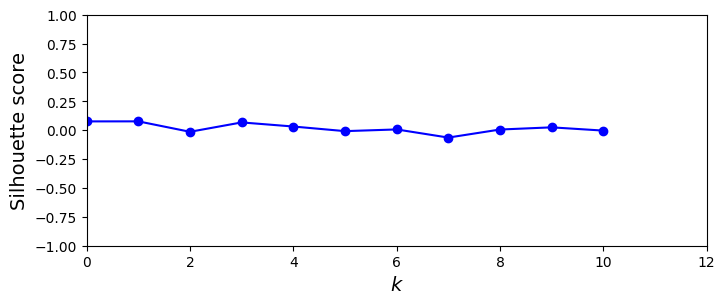

Gráficos de los coeficientes de Silhouette por cluster


ValueError: num must be an integer with 1 <= num <= 9, not 10

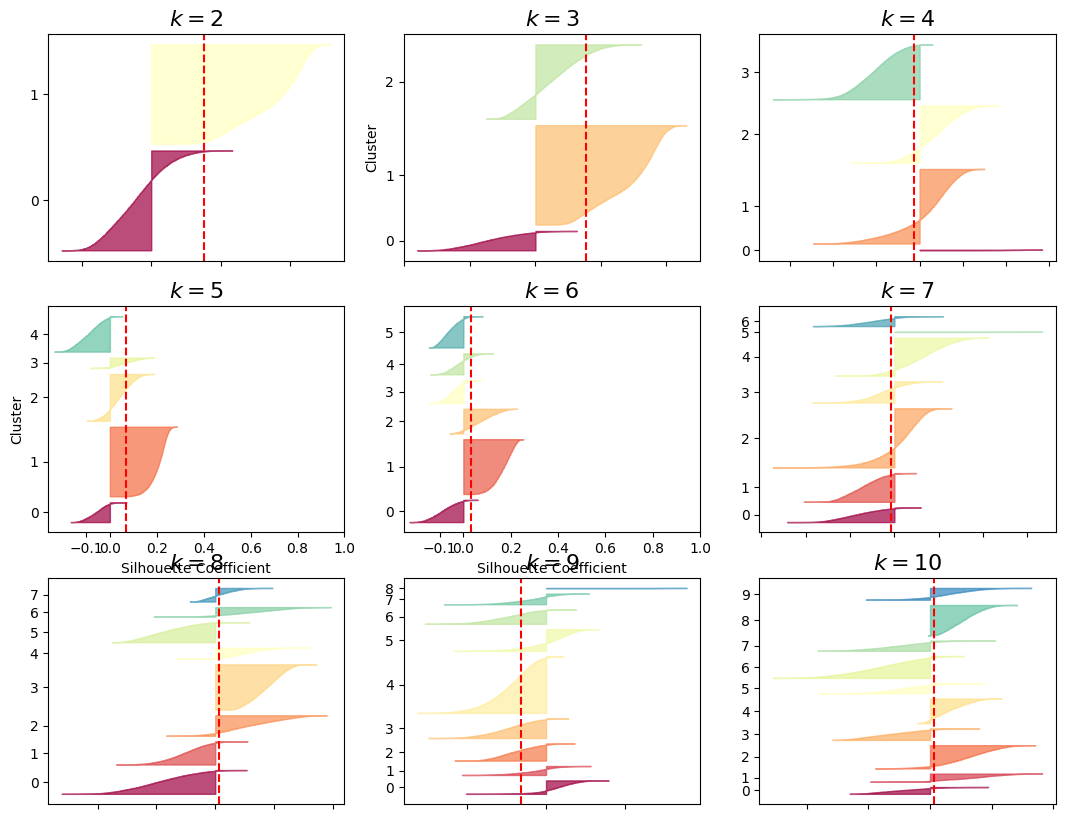

In [7]:
k_optimoJ = encontrar_numero_optimo_grupos(datasetJapanese, 12)

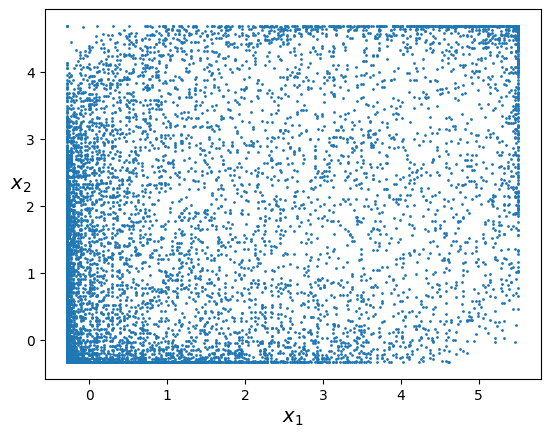

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  warnings.warn(


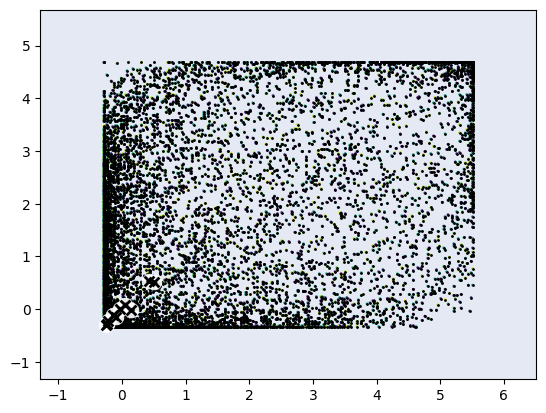

In [9]:
#kmeans_optimoJ = MiniBatchKMeans(n_clusters=k_optimoJ, random_state=42, n_init=10).
kmeans_optimoJ = MiniBatchKMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_optimoJ.fit(datasetJapanese)
graficar_clusters(datasetJapanese.values)
plt.show()
graficar_fronteras_decision(kmeans_optimoJ, datasetJapanese.values)
plt.show()
yJ = kmeans_optimoJ.labels_
datasetJapanese['labels'] = yJ

In [10]:
print(np.unique(datasetJapanese['labels']))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
modeloJ = ModelOnevsAll(datasetJapanese)
modeloJ.entrenar(True)
modeloJ.calcularPorcentajeAcierto()

<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountered in log
  costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
<ipython-input-7-88fc21bc446d>:37: RuntimeWarning: divide by zero encountere

# Pregunta N°1.2

In [ ]:
datasetConection = cargarDataset('/content/gdrive/MyDrive/SIS420/Segundo_Parcial_-_SIS420/Pregunta N°1/Dataset/CONNECTION BETWEEN HOTPOINTS AND PLANTS TYPE/CONNECTION BETWEEN HOTPOINTS AND PLANTS TYPE.xlsx - Sayfa1.csv')
datasetConection = normalizarCaracteristicas(datasetConection)

In [ ]:
k_optimoC = encontrar_numero_optimo_grupos(datasetConection, 10)

In [ ]:
kmeans_optimoC = MiniBatchKMeans(n_clusters=k_optimoC, random_state=42, n_init=10)
kmeans_optimoC.fit(datasetConection)
graficar_clusters(datasetConection.values)
plt.show()
graficar_fronteras_decision(kmeans_optimoC, datasetConection.values)
plt.show()
yC = kmeans_optimoC.labels_
datasetConection['labels'] = yC

In [ ]:
print(np.unique(datasetConection['labels']))

In [ ]:
modeloC = ModelOnevsAll(datasetConection)
modeloC.entrenar(True)
modeloC.calcularPorcentajeAcierto()

*Nota:*
El tiempo de ejecución puede extenderse hasta una hora debido a varios factores:
1. **Complejidad del algoritmo K-Means**: K-Means tiene una complejidad de O(n * k * d * i), donde n es el número de puntos de datos, k es el número de clusters, d es el número de dimensiones y i es el número de iteraciones.
2. **Dimensionalidad del conjunto de datos**: A mayor número de características (dimensiones), más tiempo requiere el algoritmo para calcular las distancias y asignar los clusters.
3. **Número de iteraciones**: El algoritmo puede necesitar muchas iteraciones para converger a una solución óptima, especialmente en datos complejos.
4. **Preprocesamiento de datos**: Incluye carga, limpieza y escalado de datos, lo que puede consumir tiempo significativo.